In [80]:
# python=3.8
# conda env name : gender_pred_env

import joblib
import numpy as np
import pandas as pd
import pickle
import warnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold
import mlflow
import mlflow.keras
from mlflow.models.signature import infer_signature
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
# Load Data
df = pd.read_pickle('data/dataset_after_preporcessing.pkl')

max_name_length = max(df['name'].apply(len))
unique_chars = set(''.join(df['name']))  
vocab_size = len(unique_chars) + 1  

with open('saved_models/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

sequences = tokenizer.texts_to_sequences(df['name'])
padded_sequences = pad_sequences(sequences, maxlen=max_name_length)
first_letter = df['name'].apply(lambda x: x[0])
last_letter = df['name'].apply(lambda x: x[-1])

first_letter_encoded = np.array([ord(char) for char in first_letter])
last_letter_encoded = np.array([ord(char) for char in last_letter])

# Load and apply the scaler models
scaler_first = joblib.load('saved_models/scaler_models/scaler_first_letter.pkl')
scaler_last = joblib.load('saved_models/scaler_models/scaler_last_letter.pkl')
first_letter_encoded_scaled = scaler_first.transform(first_letter_encoded.reshape(-1, 1))
last_letter_encoded_scaled = scaler_last.transform(last_letter_encoded.reshape(-1, 1))

# Prepare the final dataset
y = df['sex'].values
X = np.concatenate([padded_sequences, first_letter_encoded_scaled, last_letter_encoded_scaled], axis=1)

In [82]:
# Model Parameters
total_features_shape = X.shape[1]
embedding_dim = 256
lstm_units = 128
l2_lambda = 0.000
dropout_rate = 0.25
epochs = 100
batch_size = 32
patience_for_early_stopping = 5
k = 2  # Number of folds

In [83]:
# Define the model
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=total_features_shape))

model.add(Bidirectional(LSTM(lstm_units)))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=patience_for_early_stopping, 
    restore_best_weights=True
)

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 19, 256)           9472      
                                                                 
 bidirectional_19 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 403,969
Trainable params: 403,969
Non-trainable params: 0
_________________________________________________________________


In [84]:
model_architecture_str = []

# Define a function to append each line of the model summary to the list
def append_model_summary(line):
    model_architecture_str.append(line)

# Generate model summary
model.summary(print_fn=append_model_summary)

# Convert list to string
model_architecture_str = '\n'.join(model_architecture_str)

In [85]:
# MLflow setup
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Test")

kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists for fold results
fold_train_accuracies = []
fold_val_accuracies = []
fold_fpr = []
fold_tpr = []
fold_roc_auc = []
fold_accuracies = []
fold_losses = []
fold_f1_scores = []
fold_precisions = []
fold_recalls = []
fold_roc_aucs = []

with mlflow.start_run():
    mlflow.log_params({
        "embedding_dim": embedding_dim,
        "lstm_units": lstm_units,
        "epochs": epochs,
        "batch_size": batch_size,
        "l2_reg": l2_lambda,
        "dropout_rate": dropout_rate,
        "patience_for_early_stopping":patience_for_early_stopping,
        "k-folds":k
    })

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        # Split data
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Train the model
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping]
        )

        # Evaluate the model
        val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)

        # Predictions for additional metrics
        y_pred = model.predict(X_val_fold)
        y_pred_classes = np.where(y_pred > 0.5, 1, 0).reshape(-1)

        # Calculate additional metrics
        f1 = f1_score(y_val_fold, y_pred_classes)
        precision = precision_score(y_val_fold, y_pred_classes)
        recall = recall_score(y_val_fold, y_pred_classes)
        roc_auc = roc_auc_score(y_val_fold, y_pred)
        fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred)
        roc_auc = auc(fpr, tpr)

        # Log fold-specific metrics
        mlflow.log_metrics({
            f"fold_{fold+1}_accuracy": val_accuracy,
            f"fold_{fold+1}_loss": val_loss,
            f"fold_{fold+1}_f1_score": f1,
            f"fold_{fold+1}_precision": precision,
            f"fold_{fold+1}_recall": recall,
            f"fold_{fold+1}_roc_auc": roc_auc,
        }, step=fold)

        # Store the history
        fold_train_accuracies.append(history.history['accuracy'])
        fold_val_accuracies.append(history.history['val_accuracy'])

        # Store metrics for average calculation
        fold_accuracies.append(val_accuracy)
        fold_losses.append(val_loss)
        fold_f1_scores.append(f1)
        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_roc_aucs.append(roc_auc)
        fold_fpr.append(fpr)
        fold_tpr.append(tpr)
        fold_roc_auc.append(roc_auc)

        # Reset model states
        model.reset_states()

    # Calculate average metrics across all folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_loss = np.mean(fold_losses)
    avg_f1 = np.mean(fold_f1_scores)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_roc_auc = np.mean(fold_roc_aucs)
    avg_cm = np.mean(np.array(fold_cm), axis=0)
    avg_train_accuracies = np.mean(fold_train_accuracies, axis=0)
    avg_val_accuracies = np.mean(fold_val_accuracies, axis=0)

    # Log average metrics
    mlflow.log_metrics({
        "avg_accuracy": avg_accuracy,
        "avg_loss": avg_loss,
        "avg_f1_score": avg_f1,
        "avg_precision": avg_precision,
        "avg_recall": avg_recall,
        "avg_roc_auc": avg_roc_auc,
    })

    signature = infer_signature(X, model.predict(X))
    # Log the model
    mlflow.keras.log_model(model, "model",signature=signature)

        # Set additional tags
    mlflow.set_tags({
        "Description": f"Character-Level BiLSTM with {k}-fold cross validation",
        "Encoding": "Character-Level for name | other features Converting them to their ASCII value then norm",
        "Features": ', '.join(df.columns.tolist()),
        'Number of Features': len(df.columns.tolist()),
        "Model Type": "BiLSTM",
        "model_architecture": model_architecture_str
    })

Epoch 1/100
136/136 [==============================] - 8s 44ms/step - loss: 0.4968 - accuracy: 0.7718 - val_loss: 0.4563 - val_accuracy: 0.7721
Epoch 2/100
136/136 [==============================] - 6s 43ms/step - loss: 0.4081 - accuracy: 0.8118 - val_loss: 0.4211 - val_accuracy: 0.8070
Epoch 3/100
136/136 [==============================] - 6s 45ms/step - loss: 0.3883 - accuracy: 0.8234 - val_loss: 0.4084 - val_accuracy: 0.8207
Epoch 4/100
136/136 [==============================] - 6s 42ms/step - loss: 0.3808 - accuracy: 0.8315 - val_loss: 0.4047 - val_accuracy: 0.8195
Epoch 5/100
136/136 [==============================] - 6s 44ms/step - loss: 0.3700 - accuracy: 0.8403 - val_loss: 0.4189 - val_accuracy: 0.8105
Epoch 6/100
136/136 [==============================] - 6s 42ms/step - loss: 0.3617 - accuracy: 0.8419 - val_loss: 0.4002 - val_accuracy: 0.8234
Epoch 7/100
136/136 [==============================] - 6s 42ms/step - loss: 0.3546 - accuracy: 0.8465 - val_loss: 0.3851 - val_accuracy:

c:\Users\FarisAlanazi\miniconda3\envs\gender_pred_env\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\FarisAlanazi\miniconda3\envs\gender_pred_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\FarisAlanazi\miniconda3\envs\gender_pred_env\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


271/271 [==============================] - 3s 9ms/step


INFO:tensorflow:Assets written to: C:\Users\FARISA~1\AppData\Local\Temp\tmp3clcnj4c\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\FARISA~1\AppData\Local\Temp\tmp3clcnj4c\model\data\model\assets


In [86]:
# Print average metrics
print()
print('-----------------------------------------------------------')
print(f"Average Validation Accuracy: {round(avg_accuracy, 3)}")
print(f"Average F1 Score: {round(avg_f1, 3)}")
print(f"Average Precision: {round(avg_precision, 3)}")
print(f"Average Recall: {round(avg_recall, 3)}")
print(f"Average ROC AUC: {round(avg_roc_auc, 3)}")
print('-----------------------------------------------------------')


-----------------------------------------------------------
Average Validation Accuracy: 0.866
Average F1 Score: 0.913
Average Precision: 0.888
Average Recall: 0.939
Average ROC AUC: 0.909
-----------------------------------------------------------


(0.0, 1.0)

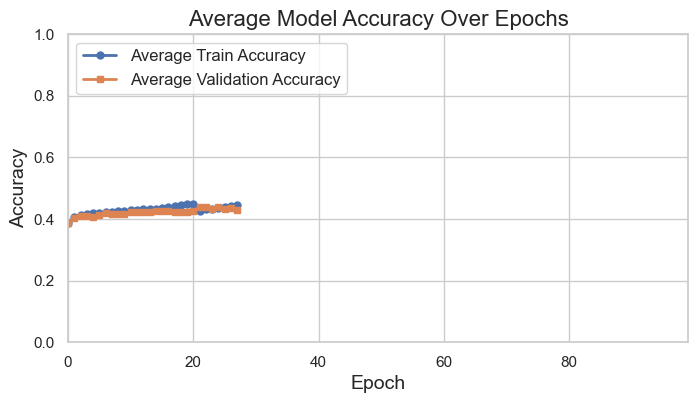

In [87]:
# Apply the seaborn style
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(8, 4))

# Plot the accuracies
plt.plot(avg_train_accuracies, label='Average Train Accuracy', linewidth=2, marker='o', markersize=5)
plt.plot(avg_val_accuracies, label='Average Validation Accuracy', linewidth=2, marker='s', markersize=5)

# Title and labels
plt.title('Average Model Accuracy Over Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

# Legend
plt.legend(loc='upper left', fontsize=12)

# Set limits for x and y axes
plt.xlim(0, epochs - 1)
plt.ylim(0, 1)  # Assuming accuracy ranges between 0 and 1

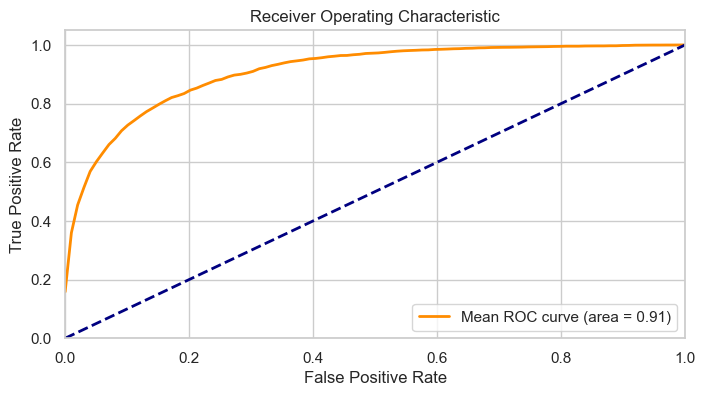

In [88]:
# Now, outside the MLflow run, average the ROC metrics and plot
avg_fpr = np.linspace(0, 1, 100)
avg_tpr = np.mean([np.interp(avg_fpr, f, t) for f, t in zip(fold_fpr, fold_tpr)], axis=0)
avg_roc_auc = auc(avg_fpr, avg_tpr)

# Plot ROC curve
plt.figure(figsize=(8, 4))
plt.plot(avg_fpr, avg_tpr, color='darkorange', lw=2,
         label='Mean ROC curve (area = %0.2f)' % avg_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

In [89]:
# Let's first collect the package versions
import streamlit
import xgboost
import tensorflow
import keras
import sklearn
import seaborn
import matplotlib
import os
# Print package versions
package_versions = {
    "streamlit": streamlit.__version__,
    "joblib": joblib.__version__,
    "xgboost": xgboost.__version__,
    "tensorflow": tensorflow.__version__,
    "keras": keras.__version__,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "sklearn": sklearn.__version__,
    "matplotlib": matplotlib.__version__,
    "seaborn": seaborn.__version__,
}

# Print versions
for package, version in package_versions.items():
    print(f"{package}: {version}")

# Now let's create a requirements file
requirements = "\n".join([f"{package}=={version}" for package, version in package_versions.items() if version != "Built-in Module"])

# Save to a requirements.txt file
requirements_file_path = 'data/requirements.txt'
with open(requirements_file_path, 'w') as file:
    file.write(requirements)

requirements_file_path

NameError: name 'os' is not defined